## extract needed data - Physician or ED notes, last entry per (person, note type) pair

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import dizzy_util as util
import pandas as pd
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_colwidth', 150)

In [3]:
dataset = util.extractDataset("B00_ML4TrgPos_", {"WithRole", "AllMed", "Vital", "HF", "DispensedDrug"})

C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


,TABLE_CATALOG,TABLE_SCHEMA,TABLE_NAME,TABLE_TYPE
0,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_01_04_cohort,BASE TABLE
1,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_05_04_Rad,BASE TABLE
2,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_30_Note_WithRole,BASE TABLE
3,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_30_Note,BASE TABLE
4,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_04_04_Lab,BASE TABLE
5,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_04_RxOutpat,BASE TABLE
6,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_07_NonVAMed,BASE TABLE
7,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_05_BCMA_DispensedDrug,BASE TABLE
8,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_06_Med_08_AllMed,BASE TABLE
9,ORD_Singh_201911038D,Dflt,_B00_ML4TrgPos_Y201621_08_Consult,BASE TABLE


C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\Local\Continuum\anaconda3\envs\ahrq-sci-med\lib\site-packages\pandas\io\sql.py:762: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
C:\Users\VHAHOUWuY1\AppData\

dict_keys(['cohort', 'Rad', 'Note', 'Lab', 'RxOutpat', 'NonVAMed', 'Consult', 'ICD', 'new', 'Demorgraphics', 'Only10daysPrior30DaysAfter'])


In [4]:
dizziness_df, label_map = util.retrieveLabels() # labeled
label_df = util.convertLabelMap(label_map) # PatientSSN | Label (100)
datasubset = util.extractAndStandarizeCohort(dataset, "Dizziness") # dataset for dizziness (All).
edstart = util.extractFirstVisitIndexDatetime(datasubset["cohort"]) # get first entry of each patient.

In [5]:
dizziness_df["DxErrorERCoded"].value_counts()

NoMOD       44
MOD         38
PMOD        12
CodingEr     6
Name: DxErrorERCoded, dtype: int64

In [6]:
datasubset["cohort"] = datasubset["cohort"].merge(label_df.rename(columns={"PatientSSN":"patientSSN"})) # concat label

In [7]:
def extractSubset(ds, subsetNames):
    pkeys = util.getPrimaryKeys(dataset)
    cohort_key = pkeys["cohort"]
    cohort_subset = ds["cohort"][ds["cohort"].Label.isin(subsetNames)]
    ids = pd.DataFrame({cohort_key: cohort_subset[cohort_key].unique()})
    dss = dict()
    for table, df in ds.items():
        dss[table] = ids.merge(df, how="inner", left_on=cohort_key, right_on=pkeys[table])
        if pkeys[table] != cohort_key:
            dss[table] = dss[table].drop([cohort_key], axis = 1)
        dss[table][pkeys[table]] = dss[table][pkeys[table]].astype(int)
    return dss

In [8]:
modsubset = extractSubset(datasubset, ["MOD"]) # dizziness MOD cases
nomodsubset = extractSubset(datasubset, ["NoMOD"]) # dizziness no-MOD cases

In [9]:
print(modsubset['Note'].columns)

Index(['PatientSSN', 'EntryDateTime', 'TIUDocumentSID', 'TIUStandardTitle',
       'ReportText', 'Sta3n', 'PatientSID', 'ProviderRole'],
      dtype='object')


In [10]:
def getEDorPhysician(df):
    pattern = 'EMERGENCY DEPT NOTE|PHYSICIAN NOTE'
    return df[df.TIUStandardTitle.str.contains(pattern)]

In [11]:
mod_ed_or_physician_df = getEDorPhysician(modsubset['Note']).sort_values("EntryDateTime")

In [12]:
nomod_ed_or_physician_df = getEDorPhysician(nomodsubset['Note']).sort_values("EntryDateTime")

In [13]:
print(mod_ed_or_physician_df['TIUStandardTitle'].unique())

['NURSING EMERGENCY DEPT NOTE' 'EMERGENCY DEPT NOTE'
 'PRIMARY CARE PHYSICIAN NOTE' 'PHYSICAL MEDICINE REHAB PHYSICIAN NOTE'
 'ATTENDING EMERGENCY DEPT NOTE' 'MENTAL HEALTH PHYSICIAN NOTE'
 'PHYSICIAN NOTE' 'NEUROLOGY PHYSICIAN NOTE'
 'PHYSICIAN EMERGENCY DEPT NOTE' 'UROLOGY PHYSICIAN NOTE'
 'SCANNED EMERGENCY DEPT NOTE' 'PULMONARY PHYSICIAN NOTE'
 'PHYSICAL THERAPY PHYSICIAN NOTE' 'ANESTHESIOLOGY PHYSICIAN NOTE'
 'DERMATOLOGY PHYSICIAN NOTE' 'PALLIATIVE CARE PHYSICIAN NOTE'
 'SOCIAL WORK EMERGENCY DEPT NOTE' 'DIALYSIS PHYSICIAN NOTE'
 'INTERNAL MEDICINE PHYSICIAN NOTE']


In [14]:
from collections import defaultdict
def getLastEntryOfNote(df):
    idnote_to_note = defaultdict(str)
    for index, row in df.iterrows():
        idnote_to_note[(row['PatientSSN'], row['TIUStandardTitle'])] = row['ReportText']
    return idnote_to_note

In [ ]:
mod_ed_or_physician_df

In [16]:
filtered_mod_dict = getLastEntryOfNote(mod_ed_or_physician_df)
filtered_nomod_dict = getLastEntryOfNote(nomod_ed_or_physician_df)

In [17]:
filtered_mod_df = pd.DataFrame(filtered_mod_dict.values(), columns =["ReportText"])
filtered_nomod_df = pd.DataFrame(filtered_nomod_dict.values(), columns =["ReportText"])

In [18]:
mod_texts = filtered_mod_df.reset_index(drop=True)
nomod_texts = filtered_nomod_df.reset_index(drop=True)

In [19]:
import re
def preprocessing(text):
    y = ''
    if text:
        y = text.lower()
        y = re.sub(r'\\[(.*?)\\]', '', y)
        y = re.sub(r'[0-9]+\.', '', y)
        y = re.sub(r'dr\.', 'doctor', y)
        y = re.sub(r'm\.d\.', 'md', y)
        y = re.sub(r'--|__|==', '', y) 
        y = re.sub(r'y\.o\.', 'year old', y)
        y = re.sub(r'fh', 'family history', y)
        y = re.sub(r'sh:', 'social history:', y)
        y = re.sub(r'\r\n', ' ', y)
        y = re.sub(r' :', ':', y)
        y = re.sub(r'physical examination', 'physical exam', y)
        y = re.sub(r'medications/iv:', 'medications:', y)
        ######### prevent catching as section
        y = re.sub(r'consult', 'consultation', y)
        y = re.sub(r'allergies', 'allergy', y) # allergies: stay the same but allergie -> allergy
        y = re.sub(r'allergy:', 'allergies:', y)
        y = re.sub(r'past history', 'past histories', y) # past history: stay the same but history -> histories, not ran for mod.
        y = re.sub(r'past histories:', 'past history:', y) # not ran for mods.
        y = re.sub(r'/ ', '/', y)
        y = re.sub(r'plan/disposition', 'plan', y)
        y = re.sub(r'=', '', y)
        ####### 11/5 added
        y = re.sub(r'\[\]', 'not ', y)
        y = re.sub(r'\[x\]', '', y)
        y = re.sub(r':', ': ', y)
        y = re.sub(r'\.', '. ', y)
        y = re.sub(r'assessment \& plan:', 'assessment:', y)
        y = re.sub(r'vitals:', 'vital signs', y)
        y = re.sub(r'active and recently expired inpatient medications \(including supplies\):', 'medications:', y)
        y = re.sub(r'active outpatient medications \(including supplies\):', 'medications:', y)
        y = re.sub(r'active inpatient medications \(including supplies\):', 'medications:',  y)
        y = re.sub(r'active outpatient medications \(excluding supplies\):', 'medications:', y)
        y = re.sub(r'reason for visit \(chief complaint\):', 'cc:', y)
        y = re.sub(r'lab results:', 'labs:', y)
        # very specific ones
        y = re.sub(r'med reconciliation  included in this list:', 'medications:', y)
        y = re.sub(r'51 y/o wm who', 'hpi: 51 y/o wm who', y)
        y = re.sub(r'reason for visit \(cc\):', 'cc:', y)
        y = re.sub(r'gen:', 'general:', y)
        y = re.sub(r'68 year old male appears', 'general: 68 year old male appears', y)
        y = re.sub(r'cc-', 'cc:', y)
        y = re.sub(r'hpi-', 'hpi:', y)
        y = re.sub('  +', ' ', y)  # whitespace
        # new
        y = re.sub(r'y/o', 'year old', y)  
        y = re.sub(r'/', ' ', y)
        #y = re.sub(r'|', ' ', y)
    return y

In [ ]:
pd.set_option('display.max_colwidth', 150)
mod_texts['ReportText'] = mod_texts['ReportText'].map(preprocessing)
mod_texts

In [ ]:
nomod_texts['ReportText'] = nomod_texts['ReportText'].map(preprocessing)
nomod_texts

##  Build Bag Of Cuis Vector

In [22]:
import spacy
import medspacy
from medspacy.visualization import visualize_ent, visualize_dep
from medspacy.custom_tokenizer import create_medspacy_tokenizer
from medspacy.section_detection import Sectionizer
from medspacy.section_detection import SectionRule
#from quickumls import QuickUMLS
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd

In [23]:
nlp = medspacy.load("en_core_sci_sm")
nlp.disable_pipe('parser')
nlp.disable_pipe('medspacy_target_matcher') # matcher: disable warning, ok doesn't help.

In [24]:
sectionizer = nlp.add_pipe("medspacy_sectionizer", config={"rules": "default"})
section_patterns = [
    SectionRule(category="history",literal="past medical/surgical history:"),
    SectionRule(category="history",literal="medical history:"),
    SectionRule(category="history",literal="surgical history:"),
    # added
    SectionRule(category="history",literal="cvabackground:"),
    SectionRule(category="status",literal="patient care status:"),
    SectionRule(category="other",literal="other:"),
    SectionRule(category="treatment",literal="treatments/therapies:"),
    SectionRule(category="preview",literal="subjectives:"),
    SectionRule(category="diagnosis",literal="diagnosis:",pattern=[{"LOWER": {"REGEX": ".*admi(tting|ssion)"}}, {"LOWER": "diagnosis"}, {"LOWER": ":"}]),
    SectionRule(category="review",literal="review of system:"),
    SectionRule(category="diagnosis",literal="assessment/diagnosis:"),
    SectionRule(category="status",literal="general:"),
    SectionRule(category="followup",literal="discussed with pt:"),
    
]
sectionizer.add(section_patterns)

nlp.pipe_names

['tok2vec',
 'tagger',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'medspacy_pyrush',
 'medspacy_context',
 'medspacy_sectionizer']

## Extract Sections Other than Medications

In [25]:
avoidsections = ['medications:', 'active medications:', 'current medications:', 'discharge medications:', 'other:', 'education:']

In [26]:
def getSection(text):
    filteredtext = ""
    current_doc = nlp(text)  
    for title, body in zip(current_doc._.section_titles, current_doc._.section_bodies):
        if title.text not in avoidsections:
            filteredtext += body.text
            filteredtext += " "
    return filteredtext

In [27]:
mod_texts['ReportText'] = mod_texts['ReportText'].map(getSection)
nomod_texts['ReportText'] = nomod_texts['ReportText'].map(getSection)

In [ ]:
mod_texts

In [ ]:
nomod_texts

In [30]:
def getAllCuisAndCuiDict(df, allCuis):
    noteToCuis = defaultdict(list)    
    for index, row in df.iterrows():
        current_doc = nlp(row['ReportText'])        
        for entity in current_doc.ents:
            noteToCuis[index] += [entity.lemma_] ### text -> lemma_
            allCuis[entity.lemma_] += 1 ### text -> lemma_
    return allCuis, noteToCuis

In [31]:
import collections
allCuis = collections.Counter() # just in case we need TF-IDF vector in the future.
allCuis, mod_note_to_cuis = getAllCuisAndCuiDict(mod_texts, allCuis)
allCuis, nomod_note_to_cuis = getAllCuisAndCuiDict(nomod_texts, allCuis)

In [32]:
allCuisListCount = allCuis.most_common(80)
allCuisList = [word for word, count in allCuisListCount]
# add risk factors
allCuisList += ['atrial fibrillation']
allCuisList += ['aneurysm']
allCuisList += ['smoke']
allCuisList += ['head trauma']
print(allCuisList)
#random.shuffle(allCuisList)

['patient', 'day', 'tablet', 'medication', 'tab', 'mouth', 'eval', 'pain', 'report', 'refill', 'negative', 'pulse', 'review', 'male', 'year', 'deny', 'intact', 'expiration', 'release', 'specimen', 'month', 'veteran', 'week', '|', 'skin', 'symptom', 'plan', 'stable', 'alert', 'discharge', 'blood', 'level', 'provider', 'collection', 'test', 'lab', 'neg', 'soft', 'state', 'outpt', 'history', 'hyperlipidemia', 'treatment', 'blood pressure', 'change', 'risk', 'auto', 'answer', 'daily', 'bilaterally', 'eye', 'egfr', 'admission', 'hypertension', 'evaluation', 'active', 'calcium', 'result', 'fever', 'increase', 'mild', 'pcp', 'htn', 'nurse', 'site', 'bilateral', 'date time', 'admit', 'dose', 'moderate', 'sob', 'lesion', 'diagnosis', 'stroke', 'abdoman', 'lung', 'please', 'visit', "patient's", 'co2', 'atrial fibrillation', 'aneurysm', 'smoke', 'head trauma']


In [62]:
blacklisted = ['patient', 'day', 'tablet', 'medication', 'tab']
n = []
for i in allCuisList:
    if i not in blacklisted:
        n += [i]

allCuisList = n
print(allCuisList)

['mouth', 'eval', 'pain', 'report', 'refill', 'negative', 'pulse', 'review', 'male', 'year', 'deny', 'intact', 'expiration', 'release', 'specimen', 'month', 'veteran', 'week', '|', 'skin', 'symptom', 'plan', 'stable', 'alert', 'discharge', 'blood', 'level', 'provider', 'collection', 'test', 'lab', 'neg', 'soft', 'state', 'outpt', 'history', 'hyperlipidemia', 'treatment', 'blood pressure', 'change', 'risk', 'auto', 'answer', 'daily', 'bilaterally', 'eye', 'egfr', 'admission', 'hypertension', 'evaluation', 'active', 'calcium', 'result', 'fever', 'increase', 'mild', 'pcp', 'htn', 'nurse', 'site', 'bilateral', 'date time', 'admit', 'dose', 'moderate', 'sob', 'lesion', 'diagnosis', 'stroke', 'abdoman', 'lung', 'please', 'visit', "patient's", 'co2', 'atrial fibrillation', 'aneurysm', 'smoke', 'head trauma']


In [63]:
# make Cui to index dictionary.
cuiToIndex = {}
for index, cui in enumerate(allCuisList):
    cuiToIndex[cui] = index

In [64]:
import numpy as np
bagOfCuisVector = np.zeros((len(mod_texts)+len(nomod_texts), len(allCuisList)))

In [65]:
def populateBOC(bagOfCuisVector, noteToCuis, shifter=0):
    for noteIndex, cuiList in noteToCuis.items():
        for cui in cuiList:
            if cui in cuiToIndex:
                bagOfCuisVector[noteIndex + shifter][cuiToIndex[cui]] = 1
    return bagOfCuisVector

In [66]:
bagOfCuisVector = populateBOC(bagOfCuisVector, mod_note_to_cuis)
bagOfCuisVector = populateBOC(bagOfCuisVector, nomod_note_to_cuis, len(mod_note_to_cuis))

In [67]:
print("number of cuis extracted in each notes:\n", bagOfCuisVector.sum(1))

number of cuis extracted in each notes:
 [ 5.  6. 15. 33. 14. 18. 27.  6. 26. 18. 24.  1. 12.  2.  8.  5. 19.  6.
  5. 13.  6. 20.  2. 12. 13.  6. 19.  3. 15.  6.  1.  0. 38.  1.  6. 11.
 20.  4.  5.  1.  1.  3. 14. 14. 15.  2. 11.  0. 29.  5.  2. 27.  1.  4.
  7.  0.  2. 26.  1.  2. 10. 13. 20.  4. 14. 15.  6.  1. 19.  1.  0. 14.
  1.  4. 26. 21. 37. 24. 11.  2. 14.  4. 24.  3.  8.  1.  7.  0. 17.  2.
  4. 15. 14.  5. 15. 15.  0.  3. 25.  5. 30. 10.  2.  2. 25. 18. 12. 27.
 36.  6. 34. 18. 20. 10.  4. 26.  7. 47.  8.  0. 12.  6. 28. 28. 18.  6.
  6. 27.  9.  5.  2.  5. 36.  8. 13. 19.  3. 26. 13. 16. 15.  5. 28. 12.
 30. 11.  0. 19.  1. 25. 39. 23. 15.  2.  5.  0. 15. 19.  1. 18. 22. 15.
 13.  4. 20. 10. 14.  7.  6. 44. 22. 14. 15. 13. 10.  3. 24.  4. 16.  4.
  3.  2.  9. 25.  0.]


In [68]:
prevalent = np.where(bagOfCuisVector.sum(0) > 185*0.5)
print(prevalent[0])
# vector is pretty sparse.

[]


In [69]:
modVector = bagOfCuisVector[:len(mod_texts)]
nomodVector = bagOfCuisVector[len(mod_texts):]

In [70]:
print(max(modVector.sum(0)))
cui_count = modVector.sum(0)
print(cui_count)

27.0
[ 8.  5. 21. 24.  3. 21. 24. 27. 27. 27. 18. 16.  2.  0.  7. 13. 11. 21.
  0. 17. 22. 16. 12. 25. 14.  8. 10.  6.  7.  7. 19.  3. 24. 15.  3. 16.
 20.  8. 14. 13. 12.  4. 18.  8.  6. 10. 12.  9. 14.  9. 10. 14. 14. 10.
 10. 10. 11. 10. 10.  8.  6.  5. 12.  5.  8. 11.  8. 14. 13. 13. 12.  5.
 13. 12. 13.  6.  0.  2.  1.]


Text(0.5, 1.0, 'cuis distribution in mod notes, sectionized')

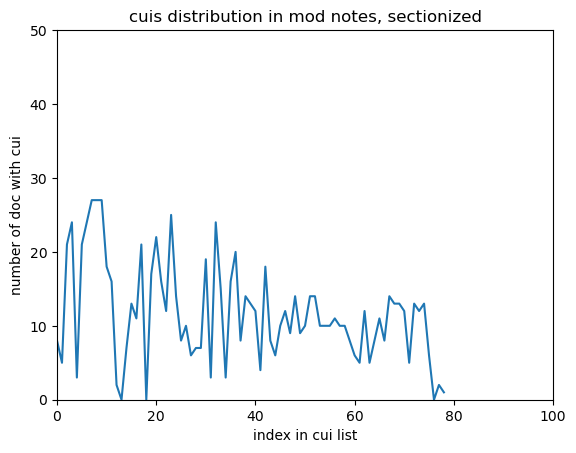

In [71]:
modcuifreq = modVector.sum(0)
plt.plot(modcuifreq) # draw this as line graph since too much argument for bar.
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.xlabel("index in cui list")
plt.ylabel("number of doc with cui")
plt.title("cuis distribution in mod notes, sectionized")

Text(0.5, 1.0, 'cuis distribution in nomod notes, sectionized')

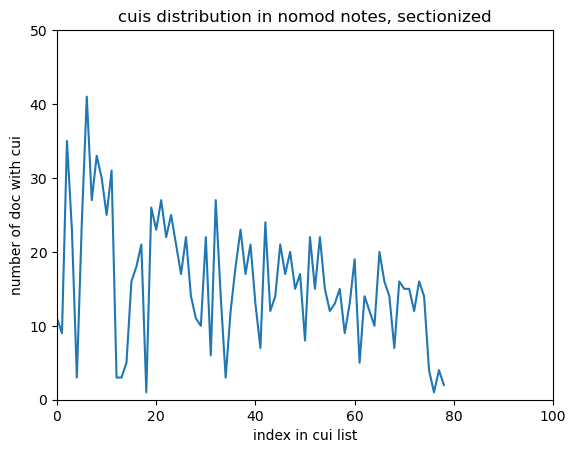

In [72]:
nomodcuifreq = nomodVector.sum(0)
plt.plot(nomodcuifreq)
plt.xlim([0, 100])
plt.ylim([0, 50])
plt.xlabel("index in cui list")
plt.ylabel("number of doc with cui")
plt.title("cuis distribution in nomod notes, sectionized")

## Hamming Distance

In [73]:
from scipy.spatial.distance import hamming

In [74]:
# bagOfCuisVector: 185 x 1000
def getHammings(standardNoteIndex):
    standard = bagOfCuisVector[standardNoteIndex]
    IndexToHammings = {}
    for i in range(len(bagOfCuisVector)): # 185
        if i != standardNoteIndex:
            vector = bagOfCuisVector[i]
            IndexToHammings[i] = hamming(standard, vector) * len(standard) # percentage of correspoinding elements that differ * len
    return sorted(IndexToHammings.items(), key = lambda v: v[1])

modSortedHammings0 = getHammings(0)
print(modSortedHammings0[0])
modSortedHammings1 = getHammings(1)
print(modSortedHammings1[0])

(85, 4.0)
(30, 5.0)


In [ ]:
mod_texts['ReportText'][0]

In [ ]:
mod_texts['ReportText'][85]

In [77]:
for index, i in enumerate(modVector[0]):
    if i > 0:
        print(allCuisList[index])

intact
hyperlipidemia
answer
bilateral
diagnosis


In [78]:
for index, i in enumerate(modVector[85]):
    if i > 0:
        print(allCuisList[index])

bilateral


# Hamming, knn

In [79]:
k = 5
modCounts = []
for i in range(185):
    modSortedHammings = getHammings(i)
    modCounts += [np.sum([1 if index < 87 else 0 for index, _ in modSortedHammings[:k]])]

In [80]:
print(modCounts)

[5, 4, 3, 2, 4, 3, 4, 5, 1, 4, 4, 5, 2, 4, 4, 5, 3, 5, 4, 4, 3, 4, 4, 4, 2, 4, 4, 5, 4, 3, 4, 3, 2, 4, 5, 5, 5, 4, 4, 4, 5, 5, 5, 2, 1, 5, 3, 3, 5, 4, 5, 2, 4, 4, 4, 3, 4, 3, 4, 5, 5, 4, 4, 5, 4, 3, 5, 4, 3, 5, 3, 5, 5, 4, 5, 2, 0, 5, 3, 4, 5, 4, 4, 4, 3, 4, 4, 4, 3, 5, 4, 2, 3, 4, 5, 2, 4, 5, 2, 5, 1, 5, 5, 5, 3, 5, 4, 3, 1, 2, 4, 3, 3, 3, 4, 2, 5, 3, 5, 4, 5, 4, 0, 4, 4, 4, 5, 2, 5, 4, 5, 5, 2, 5, 4, 2, 5, 3, 1, 4, 2, 2, 2, 2, 1, 5, 4, 3, 5, 2, 1, 4, 3, 5, 5, 4, 3, 3, 5, 4, 5, 4, 2, 4, 2, 5, 5, 4, 5, 3, 2, 3, 1, 4, 5, 4, 2, 5, 1, 5, 5, 4, 3, 4, 4]


In [81]:
modClosestToMod = sum([1 if i > 2 else 0 for i in modCounts[:87]])
nomodClosestToNomod = sum([1 if i < 3 else 0 for i in modCounts[87:]])
print(modClosestToMod, "/ 87 of mod are determined as mod,", nomodClosestToNomod, "/ 98 of nomod are determined as nomod")

77 / 87 of mod are determined as mod, 25 / 98 of nomod are determined as nomod


In [82]:
# 75, 28
# 72, 19